<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/4_hyperparameter_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

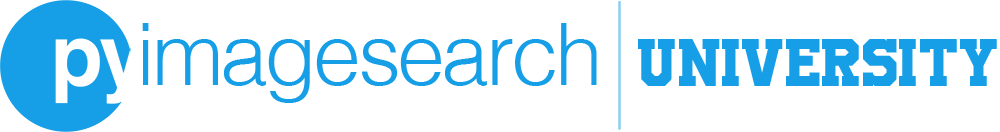

# Easy Hyperparameter Tuning with Keras Tuner and TensorFlow
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Easy Hyperparameter Tuning with Keras Tuner and TensorFlow](https://www.pyimagesearch.com/2021/06/07/easy-hyperparameter-tuning-with-keras-tuner-and-tensorflow/) blog post published on 2021-06-07.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Install the necessary packages

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 96 kB 1.8 MB/s 


### Download the code zip file

In [2]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/hyperparameter-keras-tuner/hyperparameter-keras-tuner.zip
!unzip -qq hyperparameter-keras-tuner.zip
%cd hyperparameter-keras-tuner

--2021-08-25 19:05:34--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/hyperparameter-keras-tuner/hyperparameter-keras-tuner.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.184.169
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.184.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142561 (139K) [binary/octet-stream]
Saving to: ‘hyperparameter-keras-tuner.zip’

hyperparameter-kera 100%[===================>] 139.22K  --.-KB/s    in 0.04s   

2021-08-25 19:05:34 (3.19 MB/s) - ‘hyperparameter-keras-tuner.zip’ saved [142561/142561]

/content/hyperparameter-keras-tuner


## Blog Post Code

### Import Packages

In [3]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary package
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import kerastuner as kt
import numpy as np
import argparse
import cv2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


### Implementing our Config class

In [4]:
class Config:
    # define the path to our output directory
    OUTPUT_PATH = "output"

    # initialize the input shape and number of classes
    INPUT_SHAPE = (28, 28, 1)
    NUM_CLASSES = 10

    # define the total number of epochs to train, batch size, and the
    # early stopping patience
    EPOCHS = 50
    BS = 32
    EARLY_STOPPING_PATIENCE = 5

# instantiate an object of the configuration class
config = Config()

### Implementing our plotting helper function

In [5]:
def save_plot(H, path):
	# plot the training loss and accuracy
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend()
	plt.savefig(path)

### Creating our CNN

In [6]:
def build_model(hp):
	# initialize the model along with the input shape and channel
	# dimension
	model = Sequential()
	inputShape = config.INPUT_SHAPE
	chanDim = -1

	# first CONV => RELU => POOL layer set
	model.add(Conv2D(
		hp.Int("conv_1", min_value=32, max_value=96, step=32),
		(3, 3), padding="same", input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# second CONV => RELU => POOL layer set
	model.add(Conv2D(
		hp.Int("conv_2", min_value=64, max_value=128, step=32),
		(3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	# first (and only) set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(hp.Int("dense_units", min_value=256,
		max_value=768, step=256)))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# softmax classifier
	model.add(Dense(config.NUM_CLASSES))
	model.add(Activation("softmax"))

	# initialize the learning rate choices and optimizer
	lr = hp.Choice("learning_rate",
		values=[1e-1, 1e-2, 1e-3])
	opt = Adam(learning_rate=lr)

	# compile the model
	model.compile(optimizer=opt, loss="categorical_crossentropy",
		metrics=["accuracy"])

	# return the model
	return model

### Implementing hyperparameter tuning with Keras Tuner

In [7]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-t", "--tuner", required=True, type=str,
# 	choices=["hyperband", "random", "bayesian"],
# 	help="type of hyperparameter tuner we'll be using")
# ap.add_argument("-p", "--plot", required=True,
# 	help="path to output accuracy/loss plot")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"tuner": "random",
	"plot": "output/random_plot.png"
}

In [8]:
# load the Fashion MNIST dataset
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

# add a channel dimension to the dataset
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

[INFO] loading Fashion MNIST...
4431872/4422102 [==============================] - 0s 0us/step


In [9]:
# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(
	monitor="val_loss",
	patience=config.EARLY_STOPPING_PATIENCE,
	restore_best_weights=True)

In [10]:
# check if we will be using the hyperband tuner
if args["tuner"] == "hyperband":
	# instantiate the hyperband tuner object
	print("[INFO] instantiating a hyperband tuner object...")
	tuner = kt.Hyperband(
		build_model,
		objective="val_accuracy",
		max_epochs=config.EPOCHS,
		factor=3,
		seed=42,
		directory=config.OUTPUT_PATH,
		project_name=args["tuner"])

# check if we will be using the random search tuner
elif args["tuner"] == "random":
	# instantiate the random search tuner object
	print("[INFO] instantiating a random search tuner object...")
	tuner = kt.RandomSearch(
		build_model,
		objective="val_accuracy",
		max_trials=10,
		seed=42,
		directory=config.OUTPUT_PATH,
		project_name=args["tuner"])

# otherwise, we will be using the bayesian optimization tuner
else:
	# instantiate the bayesian optimization tuner object
	print("[INFO] instantiating a bayesian optimization tuner object...")
	tuner = kt.BayesianOptimization(
		build_model,
		objective="val_accuracy",
		max_trials=10,
		seed=42,
		directory=config.OUTPUT_PATH,
		project_name=args["tuner"])

[INFO] instantiating a random search tuner object...


In [11]:
# perform the hyperparameter search
print("[INFO] performing hyperparameter search...")
tuner.search(
	x=trainX, y=trainY,
	validation_data=(testX, testY),
	batch_size=config.BS,
	callbacks=[es],
	epochs=config.EPOCHS
)

# grab the best hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of filters in conv_1 layer: {}".format(
	bestHP.get("conv_1")))
print("[INFO] optimal number of filters in conv_2 layer: {}".format(
	bestHP.get("conv_2")))
print("[INFO] optimal number of units in dense layer: {}".format(
	bestHP.get("dense_units")))
print("[INFO] optimal learning rate: {:.4f}".format(
	bestHP.get("learning_rate")))

Trial 10 Complete [00h 01m 28s]
val_accuracy: 0.8831999897956848

Best val_accuracy So Far: 0.9258000254631042
Total elapsed time: 00h 18m 04s
INFO:tensorflow:Oracle triggered exit
[INFO] optimal number of filters in conv_1 layer: 96
[INFO] optimal number of filters in conv_2 layer: 64
[INFO] optimal number of units in dense layer: 512
[INFO] optimal learning rate: 0.0010


In [12]:
# build the best model and train it
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
H = model.fit(x=trainX, y=trainY,
	validation_data=(testX, testY), batch_size=config.BS,
	epochs=config.EPOCHS, callbacks=[es], verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

# generate the training loss/accuracy plot
save_plot(H, args["plot"])

[INFO] training the best model...
Epoch 1/50
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4226 - accuracy: 0.8544 - val_loss: 0.2987 - val_accuracy: 0.8898
Epoch 2/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2920 - accuracy: 0.8946 - val_loss: 0.2591 - val_accuracy: 0.9078
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2530 - accuracy: 0.9093 - val_loss: 0.2977 - val_accuracy: 0.8961
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2344 - accuracy: 0.9142 - val_loss: 0.2700 - val_accuracy: 0.9001
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2141 - accuracy: 0.9212 - val_loss: 0.2450 - val_accuracy: 0.9134
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1955 - accuracy: 0.9290 - val_loss: 0.2321 - val_accuracy: 0.9183
Epoch 7/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1780 - accuracy: 0.935

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Easy Hyperparameter Tuning with Keras Tuner and TensorFlow*](https://www.pyimagesearch.com/2021/06/07/easy-hyperparameter-tuning-with-keras-tuner-and-tensorflow/) published on 2021-06-07.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```